# anchor


## 将真实的bbox分配给我们生成的anchor

| 说明 | 例子 |
| :------------------------: | :----------------: |
| 实际bbox与anchor的相交情况 | ![1](image/anchor_bbox_map1.png) |
| 根据IOU分配anchor | ![2](image/anchor_bbox_map2.png) |


In [1]:
from utils.bbox import *

In [2]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """
    将最接近的真实边界框分配给锚框
    @param ground_truth: 真实边界框，形状为(num_gt_boxes, 4)
    @param anchors: 锚框，形状为(num_anchors, 4)
    @param device: 设备
    @param iou_threshold: 交并比阈值
    @return: anchors_bbox_map: 每个锚框分配的真实边界框的张量，形状为(num_anchors,)
    """
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1) # dim=1表示沿着第1维度操作，即每一行取最大值和列索引
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1) # 取出大于阈值的列索引
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j

    # 为每个真实边界框分配锚框，每分配一个取消掉该锚框和真实边界框的IoU所在的行和列（即置为-1）
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard

    return anchors_bbox_map

In [3]:
ground_truth = torch.tensor([[0.0, 0.0, 1.0, 1.0],
                        [0.0, 0.0, 0.5, 0.5]])
anchors = torch.tensor([[1.0, 1.0, 2.0, 2.0],
                        [0.5, 0.5, 1.0, 1.0],
                        [0.0, 0.0, 0.5, 0.5]])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
iou_threshold = 0.5

In [4]:
num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
print("num_anchors: ", num_anchors)
print("num_gt_boxes: ", num_gt_boxes)
# 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
jaccard = box_iou(anchors, ground_truth)
print("jaccard: ", jaccard)

num_anchors:  3
num_gt_boxes:  2
jaccard:  tensor([[0.0000, 0.0000],
        [0.2500, 0.0000],
        [0.2500, 1.0000]])


In [5]:
# 对于每个锚框，初始化分配的真实边界框的张量
anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                device=device)
print("anchors_bbox_map: ", anchors_bbox_map)

anchors_bbox_map:  tensor([-1, -1, -1])


In [6]:
# 根据阈值，决定是否分配真实边界框
max_ious, indices = torch.max(jaccard, dim=1) # dim=1表示沿着第1维度操作，即每一行取最大值和列索引
print("max_ious: ", max_ious)
print("indices: ", indices)

max_ious:  tensor([0.0000, 0.2500, 1.0000])
indices:  tensor([0, 0, 1])


In [7]:
anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1) # 取出大于阈值的行
box_j = indices[max_ious >= iou_threshold] # 取出大于阈值的列索引
print("anc_i: ", anc_i)
print("box_j: ", box_j)

anc_i:  tensor([2])
box_j:  tensor([1])


In [8]:
anchors_bbox_map[anc_i] = box_j
print("anchors_bbox_map: ", anchors_bbox_map)

anchors_bbox_map:  tensor([-1, -1,  1])


In [9]:
col_discard = torch.full((num_anchors,), -1)
row_discard = torch.full((num_gt_boxes,), -1)
print("col_discard: ", col_discard)
print("row_discard: ", row_discard)

col_discard:  tensor([-1, -1, -1])
row_discard:  tensor([-1, -1])


In [10]:
for _ in range(num_gt_boxes):
    max_idx = torch.argmax(jaccard)
    box_idx = (max_idx % num_gt_boxes).long()
    anc_idx = (max_idx / num_gt_boxes).long()
    anchors_bbox_map[anc_idx] = box_idx
    jaccard[:, box_idx] = col_discard
    jaccard[anc_idx, :] = row_discard

In [11]:
print("anchors_bbox_map: ", anchors_bbox_map)

anchors_bbox_map:  tensor([-1,  0,  1])


## 偏移量的计算

### 标记类别和偏移量

现在我们为每个锚框标记类别和偏移量，假设一个锚框$A$被分配了一个真实边界框$B$。
- 锚框$A$的类别将被标记为与$B$相同。
- 锚框$A$的偏移量将根据$B$和$A$中心坐标的相对位置以及这两个框的相对大小进行标记。

鉴于数据集内不同的框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得分布更均匀且易于拟合的偏移量。
在这里，我们介绍一种常见的变换。

给定框$A$和$B$，中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，宽度分别为$w_a$和$w_b$，高度分别为$h_a$和$h_b$。
我们可以将$A$的偏移量标记为：

$$
\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right)
$$

其中常量的默认值为 $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$ ， $\sigma_w=\sigma_h=0.2$。
这种转换在下面的 `offset_boxes` 函数中实现。


In [12]:
def offset_boxes(anchors, assigned_bbox, eps=1e-6):
    r"""
    对锚框偏移量的转换
    @param anchors: 锚框，形状为(num_anchors, 4)
    @param assigned_bbox: 分配的真实边界框，形状为(num_anchors,4)
    @param eps: 防止零除的小常数
    @return: 偏移量，形状为(num_anchors,4)
    @note: 偏移量的计算公式为：
    
    $$
    \begin{aligned}
    g_x = (x - x_a) / w_a, \\
    g_y = (y - y_a) / h_a, \\
    g_w = \log((w + \epsilon) / w_a), \\
    g_h = \log((h + \epsilon) / h_a),
    \end{aligned}
    $$
    """
    c_anchor = box_corner_to_center(anchors)
    c_assigned_bbox = box_corner_to_center(assigned_bbox)

    offset_xy = 10 * (c_assigned_bbox[:, :2] - c_anchor[:, :2]) / c_anchor[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bbox[:, 2:] / c_anchor[:, 2:])

    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

### 给anchors分配真实边界框ground_truth_bbox

如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为“背景”（background）。
背景类别的锚框通常被称为“负类”锚框，其余的被称为“正类”锚框。
我们使用真实边界框（`labels`参数）实现以下`multibox_target`函数，来[**标记锚框的类别和偏移量**]（`anchors`参数）。
此函数将背景类别的索引设置为零，然后将新类别的整数索引递增一。


In [13]:
def multibox_target(anchors, labels):
    """
    使用真实边界框标记锚框
    @param anchors: 锚框，形状为(num_anchors, 4)
    @param labels: 标签，形状为(batch_size, num_labels, 5) 这里的5表示(class, xmin, ymin, xmax, ymax)
    @return: (bbox_offset, bbox_mask, cls_labels)
    @note: 
    - bbox_offset形状为(batch_size, num_anchors * 4)
    - bbox_mask形状为(batch_size, num_anchors * 4)
    - cls_labels形状为(batch_size, num_anchors)
    """
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        # 获取一个图像的标签，形状为(1, 5)
        label = labels[i, :, :]
        # 为每个锚框分配真实边界框
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        # 为没有分配真实边界框的锚框分配背景类，即0类，具体做法是将其xmin、ymin、xmax、ymax坐标设为0
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，我们标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [14]:
anchors_bbox_map = torch.tensor([-1, -1, 0, 0.7, 0.5, 0, 0, 0, 0, 0])
((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

### 一个例子说明

In [15]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

img = plt.imread('image/catdog.jpg')
h, w = img.shape[:2]
bbox_scale = torch.tensor((w, h, w, h))

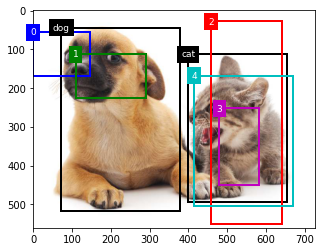

In [16]:
fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])

In [17]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

#### 分配类别

返回的结果中有三个元素，都是张量格式。第三个元素包含标记的输入锚框的类别。

让我们根据图像中的锚框和真实边界框的位置来分析下面返回的类别标签。
首先，在所有的锚框和真实边界框配对中，锚框$A_4$与猫的真实边界框的IoU是最大的。
因此，$A_4$的类别被标记为猫。
去除包含$A_4$或猫的真实边界框的配对，在剩下的配对中，锚框$A_1$和狗的真实边界框有最大的IoU。
因此，$A_1$的类别被标记为狗。
接下来，我们需要遍历剩下的三个未标记的锚框：$A_0$、$A_2$和$A_3$。
对于$A_0$，与其拥有最大IoU的真实边界框的类别是狗，但IoU低于预定义的阈值（0.5），因此该类别被标记为背景；
对于$A_2$，与其拥有最大IoU的真实边界框的类别是猫，IoU超过阈值，所以类别被标记为猫；
对于$A_3$，与其拥有最大IoU的真实边界框的类别是猫，但值低于阈值，因此该类别被标记为背景。


In [18]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

#### 设置掩码

返回的第二个元素是掩码（mask）变量，形状为（批量大小，锚框数的四倍）。
掩码变量中的元素与每个锚框的4个偏移量一一对应。
由于我们不关心对背景的检测，负类的偏移量不应影响目标函数。
通过元素乘法，掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。


In [19]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

#### 分配偏移量

返回的第一个元素包含了为每个锚框标记的四个偏移值。
请注意，负类锚框的偏移量被标记为零。


In [20]:
labels[0]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
          1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]])

## 非极大值抑制预测边界框

### anchors生成预测边界框predicted_bbox

In [21]:
def offset_inverse(anchors, offset_preds):
    """
    根据带有预测偏移量的锚框来预测边界框
    @param anchors: 锚框，形状为(num_anchors, 4) 这里的4表示(xmin, ymin, xmax, ymax)
    @param offset_preds: 预测偏移量，形状为(num_anchors, 4) 这里的4表示(delta_x, delta_y, delta_w, delta_h)
    @return: 预测边界框，形状为(num_anchors, 4)
    @note:
    - 预测边界框的4个坐标分别为(xmin, ymin, xmax, ymax)
    - 预测边界框的4个坐标值都是相对于图像宽高的比例
    - 逆函数为`offset_boxes`
    """
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

### 非极大值抑制

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。
为了简化输出，我们可以使用*非极大值抑制*（non-maximum suppression，NMS）合并属于同一目标的类似的预测边界框。

以下是非极大值抑制的工作原理。
对于一个预测边界框$B$，目标检测模型会计算每个类别的预测概率。
假设最大的预测概率为$p$，则该概率所对应的类别$B$即为预测的类别。
具体来说，我们将$p$称为预测边界框$B$的*置信度*（confidence）。
在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表$L$。然后我们通过以下步骤操作排序列表$L$：

1. 从$L$中选取置信度最高的预测边界框$B_1$作为基准，然后将所有与$B_1$的IoU超过预定阈值$\epsilon$的非基准预测边界框从$L$中移除。这时，$L$保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有*非极大值*置信度的边界框被*抑制*了。
1. 从$L$中选取置信度第二高的预测边界框$B_2$作为又一个基准，然后将所有与$B_2$的IoU大于$\epsilon$的非基准预测边界框从$L$中移除。
1. 重复上述过程，直到$L$中的所有预测边界框都曾被用作基准。此时，$L$中任意一对预测边界框的IoU都小于阈值$\epsilon$；因此，没有一对边界框过于相似。
1. 输出列表$L$中的所有预测边界框。

[**以下`nms`函数按降序对置信度进行排序并返回其索引**]。


In [22]:
def nms(boxes, scores, iou_threshold):
    """
    对预测边界框的置信度进行排序，保留置信度高的边界框，并剔除与其高度重合的边界框
    @param boxes: 预测边界框，形状为(num_anchors, 4)
    @param scores: 预测边界框的置信度，形状为(num_anchors, )
    @param iou_threshold: 非极大值抑制的阈值
    @return: 保留预测边界框的指标, 形状为(num_anchors, )
    """
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(
            boxes[i, :].reshape(-1, 4),
            boxes[B[1:], :].reshape(-1, 4)
        ).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [23]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """
    使用非极大值抑制来预测边界框
    @param cls_probs: 预测类别的概率，形状为(batch_size, num_classes, num_anchors)
    @param offset_preds: 预测边界框的偏移量，形状为(batch_size, num_anchors, 4)
    @param anchors: 锚框，形状为(1, num_anchors, 4)
    @param nms_threshold: 非极大值抑制的阈值
    @param pos_threshold: 预测类别的概率的阈值
    @return: 预测边界框，形状为(batch_size, num_anchors, 6) 这里的6表示(class_id, confidence, xmin, ymin, xmax, ymax)
    """

    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]

    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1

        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((
            class_id.unsqueeze(1),
            conf.unsqueeze(1),
            predicted_bb
        ), dim=1)
        
        out.append(pred_info)
        
    return torch.stack(out)

### 一个例子说明

In [24]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], 
                        [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], 
                        [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([
    [0] * 4,               # 背景的预测概率
    [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
    [0.1, 0.2, 0.3, 0.9]   # 猫的预测概率
    ])  

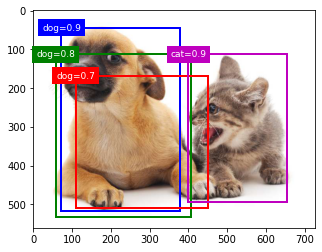

In [25]:
fig = plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [26]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])

In [27]:
output.shape

torch.Size([1, 4, 6])

> 其中output的维度为(批量大小, 锚框数, 6)，其中6个元素代表（类别，置信度，边界框）。

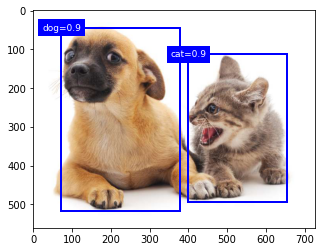

In [28]:
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    # 忽略背景类别
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)